In [217]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, SVC  # Add SVC here
from datetime import datetime
from sklearn.metrics import accuracy_score

In [218]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [219]:
df1 = pd.read_csv('/content/drive/MyDrive/files/deliveries.csv')

print(df1.shape)


(17380, 22)


In [220]:
df1.head(2)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.1,England,New Zealand,JM Bairstow,DJ Malan,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.2,England,New Zealand,JM Bairstow,DJ Malan,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
df1['over'] = df1['ball'].apply(lambda x: int(x) + 1 if x % 1 == 0 else int(x))

In [222]:
df1.head(2)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,over
0,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.1,England,New Zealand,JM Bairstow,DJ Malan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.2,England,New Zealand,JM Bairstow,DJ Malan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [223]:

# only the dot balls (runs_off_bat == 0)
dot_balls = df1[df1['runs_off_bat'] == 0]

# Group by 'bowler' and count the number of dot balls
dot_balls_count = dot_balls.groupby('bowler')['runs_off_bat'].count().reset_index(name='dot_balls_count')

# Group by 'bowler' and count the total number of balls bowled
total_balls_count = df1.groupby('bowler').size().reset_index(name='total_balls_count')

# Merge dot balls count and total balls count
merged_data = pd.merge(dot_balls_count, total_balls_count, on='bowler', how='left')

# Calculate the percentage of dot balls for each bowler
merged_data['dot_ball_percentage'] = (merged_data['dot_balls_count'] / merged_data['total_balls_count']) * 100

merged_data


,bowler,dot_balls_count,total_balls_count,dot_ball_percentage
0,A Dutt,197,317,62.145110
1,A Zampa,120,298,40.268456
2,AAP Atkinson,28,55,50.909091
3,AD Mathews,25,48,52.083333
4,AK Markram,12,24,50.000000
...,...,...,...,...
87,TG Southee,20,61,32.786885
88,Taskin Ahmed,122,217,56.221198
89,Usama Mir,96,217,44.239631
90,V Kohli,1,3,33.333333


In [224]:
# Merge the dot ball percentage data back into the original DataFrame (df1)
df1 = pd.merge(df1, merged_data[['bowler', 'dot_ball_percentage']], on='bowler', how='left')
df1.head(2)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,over,dot_ball_percentage
0,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.1,England,New Zealand,JM Bairstow,DJ Malan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,58.955224
1,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.2,England,New Zealand,JM Bairstow,DJ Malan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,58.955224


In [225]:
deliveries_data = df1
points_data = pd.read_excel('/content/drive/MyDrive/files/points.xlsx')
result_data = pd.read_csv('/content/drive/MyDrive/files/matches_final.csv')

In [226]:
result_data['winner'] = result_data['winner'].str.lower()
merged_data = pd.merge(result_data, points_data, left_on='winner', right_on='Teams', how='left')
merged_data.head(2)


,season,team1,team2,date,match_number,venue,city,toss_winner,toss_decision,player_of_match,...,Pos,Teams,Matches,Won,Lost,Tied,NR,Points,NRR,Series Form
0,2023/24,England,New Zealand,05-10-2023,1.0,Narendra Modi Stadium,Ahmedabad,New Zealand,field,R Ravindra,...,4.0,new zealand,9.0,5.0,4.0,0.0,0.0,10.0,0.743,WLLLL
1,2023/24,Pakistan,Netherlands,06-10-2023,2.0,Rajiv Gandhi International Stadium,Hyderabad,Netherlands,field,Saud Shakeel,...,5.0,pakistan,9.0,4.0,5.0,0.0,0.0,8.0,-0.199,LWWLL


In [227]:
final_data = pd.merge(merged_data, deliveries_data, left_on='match_number', right_on='match_id', how='inner')
final_data.head(2)

,season_x,team1,team2,date,match_number,venue_x,city,toss_winner,toss_decision,player_of_match,...,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,over,dot_ball_percentage
0,2023/24,England,New Zealand,05-10-2023,1.0,Narendra Modi Stadium,Ahmedabad,New Zealand,field,R Ravindra,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,58.955224
1,2023/24,England,New Zealand,05-10-2023,1.0,Narendra Modi Stadium,Ahmedabad,New Zealand,field,R Ravindra,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,58.955224


In [228]:
data = final_data.copy()

In [229]:
data.columns

Index(['season_x', 'team1', 'team2', 'date', 'match_number', 'venue_x', 'city',
       'toss_winner', 'toss_decision', 'player_of_match', 'umpire1', 'umpire2',
       'reserve_umpire', 'match_referee', 'winner', 'winner_runs',
       'winner_wickets', 'match_type', 'Pos', 'Teams', 'Matches', 'Won',
       'Lost', 'Tied', 'NR', 'Points', 'NRR', 'Series Form', 'match_id',
       'season_y', 'start_date', 'venue_y', 'innings', 'ball', 'batting_team',
       'bowling_team', 'striker', 'non_striker', 'bowler', 'runs_off_bat',
       'extras', 'wides', 'noballs', 'byes', 'legbyes', 'penalty',
       'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed', 'over', 'dot_ball_percentage'],
      dtype='object')

In [230]:
columns_to_drop = ['Won','Lost','match_number','season_x','date','umpire1','umpire2','reserve_umpire','match_referee','match_type','Pos','Matches','Tied','NR','match_id','season_y','start_date','venue_y','noballs','penalty','other_wicket_type','other_player_dismissed','Series Form','innings','Teams','player_dismissed','team1','team2','player_of_match','winner','winner_runs']

In [231]:
data = data.drop(columns_to_drop, axis=1)

In [232]:
data.shape

(17380, 21)

In [233]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17380 entries, 0 to 17379
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   venue_x              17380 non-null  object 
 1   city                 17380 non-null  object 
 2   toss_winner          17380 non-null  object 
 3   toss_decision        17380 non-null  object 
 4   winner_wickets       8555 non-null   float64
 5   Points               17380 non-null  float64
 6   NRR                  17380 non-null  float64
 7   ball                 17380 non-null  float64
 8   batting_team         17380 non-null  object 
 9   bowling_team         17380 non-null  object 
 10  striker              17380 non-null  object 
 11  non_striker          17380 non-null  object 
 12  bowler               17380 non-null  object 
 13  runs_off_bat         17380 non-null  int64  
 14  extras               17380 non-null  int64  
 15  wides                431 non-null   

In [234]:
data.describe()

,winner_wickets,Points,NRR,ball,runs_off_bat,extras,wides,byes,legbyes,over,dot_ball_percentage
count,8555.000000,17380.000000,17380.000000,17380.000000,17380.000000,17380.000000,431.000000,26.000000,117.000000,17380.000000,17380.000000
mean,6.296435,11.330495,0.616008,22.544108,0.895224,0.044649,1.225058,2.153846,1.239316,22.185040,52.825086
std,1.950709,4.647179,1.295534,13.638454,1.392734,0.285378,0.864237,1.433661,0.738703,13.636939,7.833599
min,1.000000,4.000000,-1.825000,0.100000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,16.666667
25%,5.000000,8.000000,-0.336000,10.600000,0.000000,0.000000,1.000000,1.000000,1.000000,10.000000,47.201946
50%,7.000000,10.000000,0.743000,22.100000,0.000000,0.000000,1.000000,1.000000,1.000000,22.000000,52.840909
75%,8.000000,14.000000,1.261000,33.500000,1.000000,0.000000,1.000000,4.000000,1.000000,33.000000,58.955224
max,9.000000,18.000000,2.570000,49.700000,6.000000,5.000000,5.000000,4.000000,4.000000,49.000000,68.862275


In [235]:
# correlation matrix
corr_matrix = data.corr()
corr_matrix

<ipython-input-235-50ea473bfbc5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


,winner_wickets,Points,NRR,ball,runs_off_bat,extras,wides,byes,legbyes,over,dot_ball_percentage
winner_wickets,1.000000,-0.183259,-0.110976,-0.045972,0.020276,-0.032892,-0.019762,-0.251805,0.098865,-0.045870,-0.186946
Points,-0.183259,1.000000,0.974513,0.010871,0.029612,-0.008090,-0.057645,-0.314616,0.031001,0.010900,0.084383
NRR,-0.110976,0.974513,1.000000,0.010215,0.024864,-0.014717,-0.046833,-0.293796,0.003604,0.010279,0.069105
ball,-0.045972,0.010871,0.010215,1.000000,0.068771,0.020641,-0.019383,-0.440175,0.022458,0.999914,-0.153776
runs_off_bat,0.020276,0.029612,0.024864,0.068771,1.000000,-0.088557,NaN,NaN,NaN,0.068839,-0.065295
extras,-0.032892,-0.008090,-0.014717,0.020641,-0.088557,1.000000,1.000000,1.000000,1.000000,0.020632,0.040859
wides,-0.019762,-0.057645,-0.046833,-0.019383,NaN,1.000000,1.000000,NaN,NaN,-0.018381,-0.094474
byes,-0.251805,-0.314616,-0.293796,-0.440175,NaN,1.000000,NaN,1.000000,NaN,-0.440589,0.143916
legbyes,0.098865,0.031001,0.003604,0.022458,NaN,1.000000,NaN,NaN,1.000000,0.021817,-0.036904
over,-0.045870,0.010900,0.010279,0.999914,0.068839,0.020632,-0.018381,-0.440589,0.021817,1.000000,-0.153994


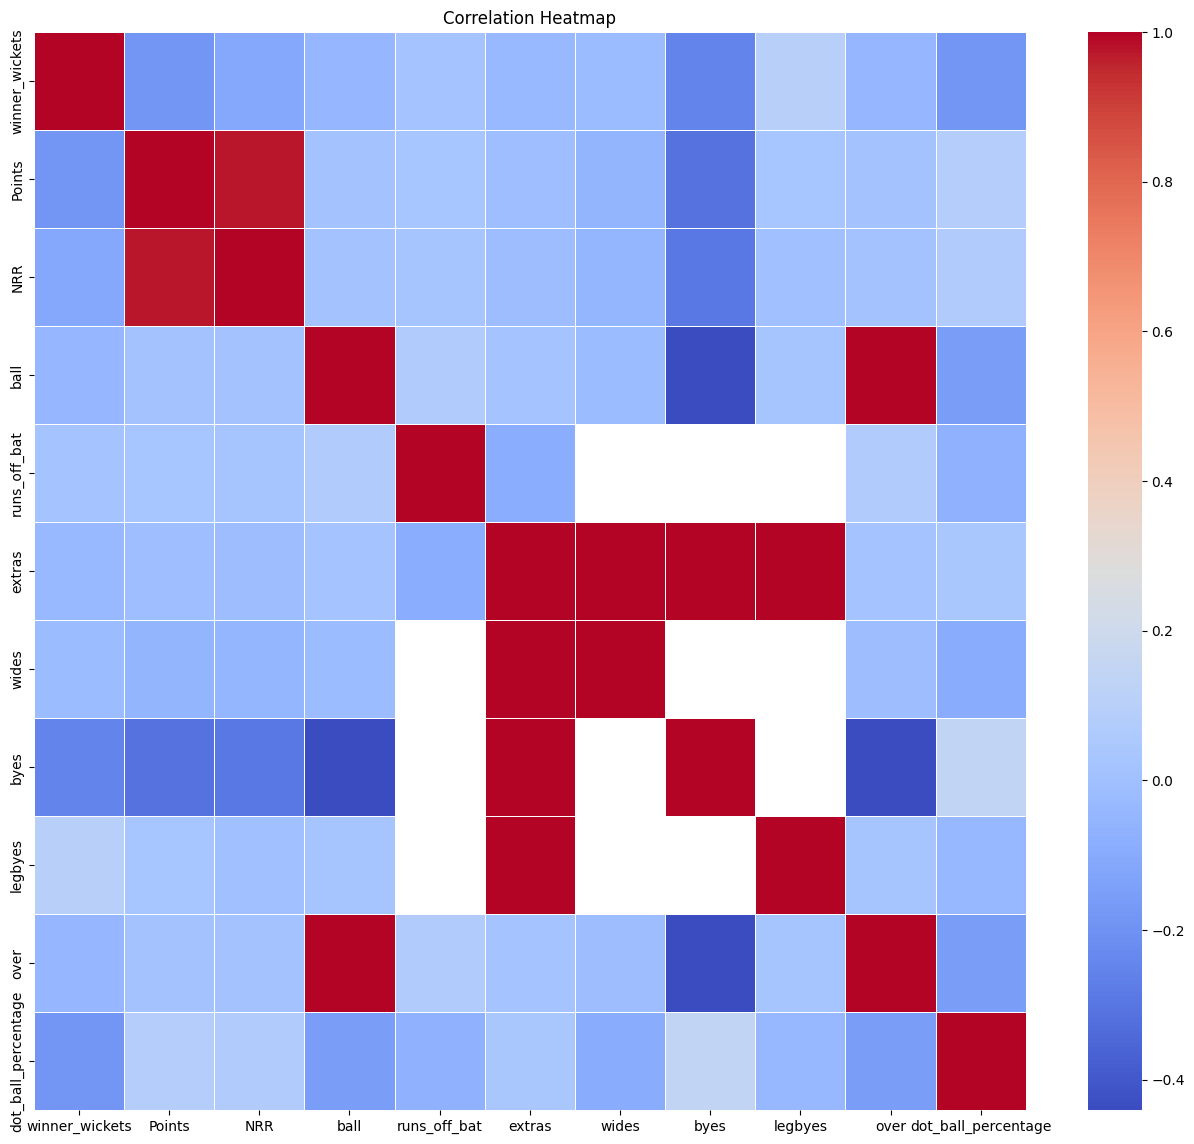

In [236]:
# heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [237]:
null_vals = data.isnull().sum()
null_vals[null_vals != 0].sort_values(ascending=False)

byes              17354
legbyes           17263
wides             16949
wicket_type       16889
winner_wickets     8825
dtype: int64

In [238]:
print(data['byes'].unique())
print(data['byes'].value_counts())
print()

print(data['legbyes'].unique())
print(data['legbyes'].value_counts())
print()

print(data['wides'].unique())
print(data['wides'].value_counts())
print()

print(data['wicket_type'].unique())
print(data['wicket_type'].value_counts())
print()



[nan  4.  1.  2.  3.]
1.0    15
4.0     9
2.0     1
3.0     1
Name: byes, dtype: int64

[nan  1.  4.  2.]
1.0    103
4.0      7
2.0      7
Name: legbyes, dtype: int64

[nan  1.  3.  5.  2.]
1.0    397
5.0     20
2.0     11
3.0      3
Name: wides, dtype: int64

[nan 'caught' 'bowled' 'caught and bowled' 'lbw' 'run out' 'stumped'
 'retired hurt']
caught               299
bowled                96
lbw                   56
run out               21
caught and bowled     10
stumped                8
retired hurt           1
Name: wicket_type, dtype: int64



In [239]:
data['byes'] = data['byes'].fillna('Unknown')
data['legbyes'] = data['legbyes'].fillna('Unknown')
data['wides'] = data['wides'].fillna('Unknown')
data['wicket_type'] = data['wicket_type'].fillna('Unknown')
data['winner_wickets'].fillna(0, inplace=True)


In [240]:
null_vals = data.isnull().sum()
null_vals[null_vals != 0].sort_values(ascending=False)

Series([], dtype: int64)

In [241]:
column_to_encode = data.select_dtypes(exclude='number').columns

In [242]:
label_encoder = LabelEncoder()

In [243]:
for column in column_to_encode:
    data[column] = data[column].astype(str)
    data[column] = label_encoder.fit_transform(data[column])

In [244]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17380 entries, 0 to 17379
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   venue_x              17380 non-null  int64  
 1   city                 17380 non-null  int64  
 2   toss_winner          17380 non-null  int64  
 3   toss_decision        17380 non-null  int64  
 4   winner_wickets       17380 non-null  float64
 5   Points               17380 non-null  float64
 6   NRR                  17380 non-null  float64
 7   ball                 17380 non-null  float64
 8   batting_team         17380 non-null  int64  
 9   bowling_team         17380 non-null  int64  
 10  striker              17380 non-null  int64  
 11  non_striker          17380 non-null  int64  
 12  bowler               17380 non-null  int64  
 13  runs_off_bat         17380 non-null  int64  
 14  extras               17380 non-null  int64  
 15  wides                17380 non-null 

In [245]:
print(data.columns)
print(data.shape)

Index(['venue_x', 'city', 'toss_winner', 'toss_decision', 'winner_wickets',
       'Points', 'NRR', 'ball', 'batting_team', 'bowling_team', 'striker',
       'non_striker', 'bowler', 'runs_off_bat', 'extras', 'wides', 'byes',
       'legbyes', 'wicket_type', 'over', 'dot_ball_percentage'],
      dtype='object')
(17380, 21)


In [246]:
# Splitting the data into train set (75%), validation set (10%) and test set (15%)
x = data.iloc[:,:-1]
y = data['dot_ball_percentage']

In [247]:
from sklearn.model_selection import train_test_split
x_train, x_part, y_train, y_part = train_test_split(x,y,test_size = 0.25,random_state = 42)
x_test, x_valid, y_test, y_valid = train_test_split(x_part,y_part,test_size = 0.25,random_state = 42)

In [248]:
print(x_train.shape,x_test.shape,x_valid.shape)
print(y_train.shape,y_test.shape,y_valid.shape)

(13035, 20) (3258, 20) (1087, 20)
(13035,) (3258,) (1087,)


In [249]:
train_scaler = StandardScaler().fit(x_train)
X_train_scaled = train_scaler.transform(x_train)

valid_scaler = StandardScaler().fit(x_valid)
X_valid_scaled = valid_scaler.transform(x_valid)

test_scaler = StandardScaler().fit(x_test)
X_test_scaled = test_scaler.transform(x_test)

In [250]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import math
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


In [251]:
# Dictionary of different models with their parameters
model_dict = {
    'LinearRegression': {"model": LinearRegression(), "params": {}},
    'RandomForestRegressor': {"model": RandomForestRegressor(random_state=42),
                              "params": {'n_estimators': list(range(5, 50, 5)), 'max_depth': list(range(1, 10, 2))}},
    'XGBRegressor': {"model": XGBRegressor(), "params": {'n_estimators': list(range(10, 800, 100)), 'learning_rate': [0.001, 0.01, 0.1]}},
    'DecisionTreeRegressor': {"model": DecisionTreeRegressor(), "params": {'max_depth': list(range(1, 10, 2))}},  # Add Decision Tree
}


In [252]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_models(X_train_scaled, y_train, X_valid_scaled, y_valid, X_test_scaled, y_test):
    model_results = pd.DataFrame()
    model_results['Train_RMSE'] = None
    model_results['Validation_RMSE'] = None
    model_results['Test_RMSE'] = None
    model_results['Train_MAE'] = None
    model_results['Validation_MAE'] = None
    model_results['Test_MAE'] = None
    model_results['Train_R2'] = None
    model_results['Validation_R2'] = None
    model_results['Test_R2'] = None
    model_results['best_params'] = None

    best_reg_model_ours = None
    best_valid_score = math.inf

    for model_name, reg_model in model_dict.items():
        classifier = GridSearchCV(reg_model['model'], reg_model['params'], n_jobs=20, verbose=0)
        classifier.fit(X_train_scaled, list(y_train))
        best_model = classifier.best_estimator_

        y_train_predicted = best_model.predict(X_train_scaled)
        train_rmse = np.sqrt(mean_squared_error(list(y_train), y_train_predicted))
        train_mae = mean_absolute_error(list(y_train), y_train_predicted)
        train_r2 = r2_score(list(y_train), y_train_predicted)

        y_valid_predicted = best_model.predict(X_valid_scaled)
        valid_rmse = np.sqrt(mean_squared_error(list(y_valid), y_valid_predicted))
        valid_mae = mean_absolute_error(list(y_valid), y_valid_predicted)
        valid_r2 = r2_score(list(y_valid), y_valid_predicted)

        y_test_predicted = best_model.predict(X_test_scaled)
        test_rmse = np.sqrt(mean_squared_error(list(y_test), y_test_predicted))
        test_mae = mean_absolute_error(list(y_test), y_test_predicted)
        test_r2 = r2_score(list(y_test), y_test_predicted)

        if valid_rmse < best_valid_score:
            best_valid_score = valid_rmse
            best_reg_model_ours = best_model

        model_results.loc[model_name, [
            'Train_RMSE', 'Validation_RMSE', 'Test_RMSE',
            'Train_MAE', 'Validation_MAE', 'Test_MAE',
            'Train_R2', 'Validation_R2', 'Test_R2',
            'best_params'
        ]] = [train_rmse, valid_rmse, test_rmse,
              train_mae, valid_mae, test_mae,
              train_r2, valid_r2, test_r2,
              classifier.best_params_]

    return model_results

# model results
model_results = eval_models(X_train_scaled, y_train, X_valid_scaled, y_valid, X_test_scaled, y_test)


In [253]:
model_results

,Train_RMSE,Validation_RMSE,Test_RMSE,Train_MAE,Validation_MAE,Test_MAE,Train_R2,Validation_R2,Test_R2,best_params
LinearRegression,7.464177,7.69836,7.422122,6.053833,6.138568,5.966744,0.092972,0.07,0.085087,{}
RandomForestRegressor,1.848614,3.683382,2.177999,0.91074,1.675788,0.943763,0.944365,0.787098,0.921216,"{'max_depth': 9, 'n_estimators': 45}"
XGBRegressor,0.043239,2.774993,3.622416,0.029582,1.178987,2.035822,0.99997,0.87916,0.782068,"{'learning_rate': 0.1, 'n_estimators': 710}"
DecisionTreeRegressor,2.041334,4.044507,2.239553,0.896609,1.782618,0.914641,0.93216,0.743305,0.9167,{'max_depth': 9}
